In [1]:
import pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math

from featureEngineering2 import feature_engineering

df=pd.read_csv('data/train.csv', sep=',')

df_f = feature_engineering(df)

df_d = feature_engineering(df, get_dummies=True)

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
df_f.head()

,Age_,Age_b,HasAge,Sex,Pclass,Fare_,HasFare,Title_,Embarked_,Cabin_,SibSp_,Parch_
0,22,5,1,male,3,7.250,1,Mr,S,X,1,0
1,38,9,1,female,1,40.000,1,Mrs,C,C,1,0
2,26,6,1,female,3,7.925,1,Miss,S,X,0,0
3,35,9,1,female,1,40.000,1,Mrs,S,C,1,0
4,35,9,1,male,3,8.050,1,Mr,S,X,0,0


In [3]:
df_d.head()

,Age_,Age_b,HasAge,Pclass,Fare_,HasFare,SibSp_,Parch_,Sex_female,Sex_male,...,Embarked__X,Cabin__A,Cabin__B,Cabin__C,Cabin__D,Cabin__E,Cabin__F,Cabin__G,Cabin__T,Cabin__X
0,22,5,1,3,7.250,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,38,9,1,1,40.000,1,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,26,6,1,3,7.925,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,35,9,1,1,40.000,1,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,35,9,1,3,8.050,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## Train, test split and StandarScaler

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_d.iloc[:].values, df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Eigenvalues and Eigenvectors

In [8]:
# calculate the covariance matrix:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) # eigendecomposition

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[  4.38236837e+00   3.53803311e+00   2.38276031e+00   1.98572544e+00
   8.22455179e-03   1.26329577e-01   1.51956481e+00   3.19054784e-01
   4.67448381e-01   5.12972509e-01   5.99834031e-01   1.35342934e+00
   1.30303887e+00   1.28425382e+00   6.61073038e-01   7.17977653e-01
   7.73796397e-01   1.14872452e+00   8.99489794e-01   9.13737528e-01
   1.05570703e+00   9.75913611e-01   1.04359042e+00   1.02803891e+00
   1.02371242e+00   1.01405229e+00   9.97476416e-01   1.00989728e+00
   1.00154552e+00   1.00621486e+00   1.00389223e+00   1.84711045e-15
   1.98485191e-15   6.90266875e-16  -2.18376695e-16   1.08568440e-18
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


In [9]:
eigen_vals.shape

(40,)

In [10]:
eigen_vecs.shape # eigenvectors (principal components)

(40, 40)

## Total and explained variance

### We want to select the subset of the eigenvectors (principal components) that contains most of the information (variance)

Since the eigenvalues define the magnitude of the eigenvectors, we have to sort the eigenvalues by decreasing magnitude.

Firstly we use [cumsum] function to calculate the cumulative sum of explained variance, which we will plot via matplotlib's step function:

In [11]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

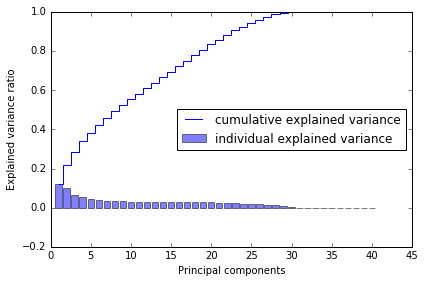

In [13]:
plt.bar(range(1, 41), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 41), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/pca1.png', dpi=300)
plt.show()

The resulting plot indicates that the first principal component alone accounts for 12% to 13% of the variance. 

We shall remind ourselvs that PCA is an unsupervised method, which means that information about the class labels is ignored.

## Feature transformation

We start by sorting the eigenpairs by decreasing order of the eigenvalues:

In [40]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(reverse=True,key=lambda x: x[0])

In [42]:
eigen_pairs

[(4.3823683741847024,
  array([-0.01271662, -0.01143947, -0.06464792,  0.2619574 , -0.31763248,
          0.        , -0.14427873, -0.17856924, -0.39946567,  0.39946567,
         -0.02268595,  0.        ,  0.        , -0.00781941,  0.        ,
         -0.03793256, -0.01799936, -0.00855681, -0.2362444 , -0.05952516,
         -0.04313994,  0.39365639, -0.25272547, -0.00858811,  0.01849596,
         -0.01808744, -0.03678245, -0.12561619,  0.02692625,  0.098774  ,
         -0.06748209, -0.01610831, -0.16695903, -0.14597055, -0.10753625,
         -0.06271184, -0.03042815, -0.03441438,  0.00285659,  0.26783574])),
 (3.5380331110554764,
  array([-0.39912285, -0.39724602, -0.07957365,  0.34929237, -0.18009927,
          0.        ,  0.18287497,  0.17199466,  0.18019033, -0.18019033,
         -0.0642158 ,  0.        ,  0.        , -0.02980965,  0.        ,
         -0.0479605 , -0.07055981,  0.17745042,  0.2322619 , -0.02821675,
         -0.0192435 , -0.22776014, -0.00417735,  0.01276165, -0.0

In [43]:
# collect the first two biggist eigenvectors
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

('Matrix W:\n', array([[-0.01271662, -0.39912285],
       [-0.01143947, -0.39724602],
       [-0.06464792, -0.07957365],
       [ 0.2619574 ,  0.34929237],
       [-0.31763248, -0.18009927],
       [ 0.        ,  0.        ],
       [-0.14427873,  0.18287497],
       [-0.17856924,  0.17199466],
       [-0.39946567,  0.18019033],
       [ 0.39946567, -0.18019033],
       [-0.02268595, -0.0642158 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.00781941, -0.02980965],
       [ 0.        ,  0.        ],
       [-0.03793256, -0.0479605 ],
       [-0.01799936, -0.07055981],
       [-0.00855681,  0.17745042],
       [-0.2362444 ,  0.2322619 ],
       [-0.05952516, -0.02821675],
       [-0.04313994, -0.0192435 ],
       [ 0.39365639, -0.22776014],
       [-0.25272547, -0.00417735],
       [-0.00858811,  0.01276165],
       [ 0.01849596, -0.01649039],
       [-0.01808744, -0.06054482],
       [-0.03678245, -0.02471664],
       [-0.12561619, -0.10999559],
    

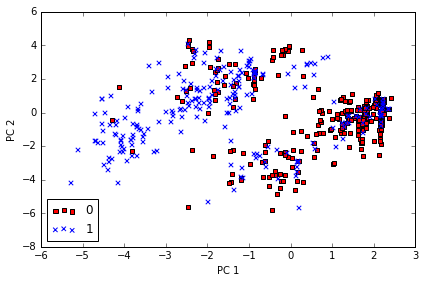

In [44]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

## Principal component analysis in scikit-learn

In [45]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([  1.21537058e-01,   9.81209468e-02,   6.60815459e-02,
         5.50705021e-02,   4.21423806e-02,   3.75349139e-02,
         3.61374255e-02,   3.56164560e-02,   3.18577961e-02,
         2.92781242e-02,   2.89420921e-02,   2.85107991e-02,
         2.83908117e-02,   2.81229056e-02,   2.80076738e-02,
         2.79055485e-02,   2.78411345e-02,   2.77760528e-02,
         2.76632036e-02,   2.70651982e-02,   2.53408571e-02,
         2.49457220e-02,   2.14598430e-02,   1.99118111e-02,
         1.83336646e-02,   1.66353116e-02,   1.42263644e-02,
         1.29638351e-02,   8.84840717e-03,   3.50352225e-03,
         2.28093063e-04,   2.39689583e-32,   8.64166275e-33,
         6.39229247e-33,   5.90547219e-33,   4.50234463e-33,
         1.82120816e-33,   4.70102913e-34,   3.42296028e-34,
         4.22833132e-35])

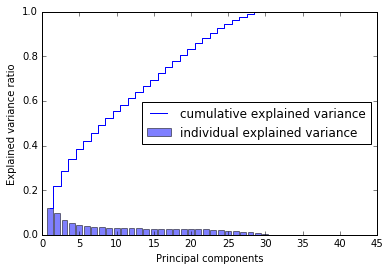

In [48]:

plt.bar(range(1, 41), pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(1, 41), np.cumsum(pca.explained_variance_ratio_), where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

## PCA with sklearn

In [49]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

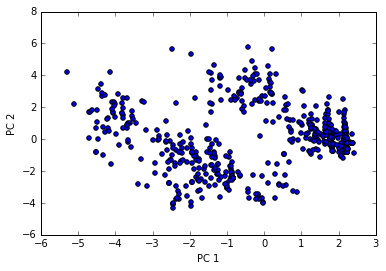

In [50]:
plt.scatter(X_train_pca[:,0], X_train_pca[:,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [51]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

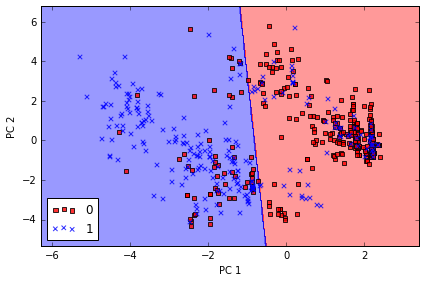

In [56]:
# Train data:

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca3.png', dpi=300)
plt.show()

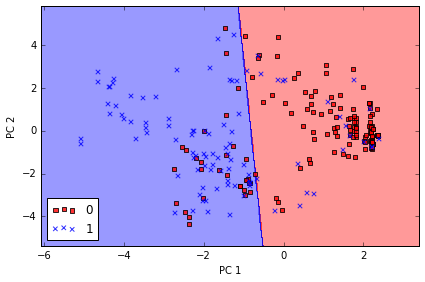

In [57]:
# Test data:

plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca4.png', dpi=300)
plt.show()

# View the explained variance ratio for all components:

In [61]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([  1.21537058e-01,   9.81209468e-02,   6.60815459e-02,
         5.50705021e-02,   4.21423806e-02,   3.75349139e-02,
         3.61374255e-02,   3.56164560e-02,   3.18577961e-02,
         2.92781242e-02,   2.89420921e-02,   2.85107991e-02,
         2.83908117e-02,   2.81229056e-02,   2.80076738e-02,
         2.79055485e-02,   2.78411345e-02,   2.77760528e-02,
         2.76632036e-02,   2.70651982e-02,   2.53408571e-02,
         2.49457220e-02,   2.14598430e-02,   1.99118111e-02,
         1.83336646e-02,   1.66353116e-02,   1.42263644e-02,
         1.29638351e-02,   8.84840717e-03,   3.50352225e-03,
         2.28093063e-04,   2.39689583e-32,   8.64166275e-33,
         6.39229247e-33,   5.90547219e-33,   4.50234463e-33,
         1.82120816e-33,   4.70102913e-34,   3.42296028e-34,
         4.22833132e-35])